<h1> 8. 인물사진을 만들어 보자 <h1>

## 학습목표

- 딥러닝을 적용하여 핸드폰 인물 사진 모드를 따라 해 보자.

## 목차

- 들어가며, 인물사진 모드란?

- 셸로우 포커스 만들기 (1) 사진을 준비하자

- 셸로우 포커스 만들기 (2) 세그멘테이션으로 사람 분리하기

- 셸로우 포커스 만들기 (3) 시맨틱 세그멘테이션 다뤄보기

- 셸로우 포커스 만들기 (4) 세그멘테이션 결과를 원래 크기로 복원하기

- 셸로우 포커스 만들기 (5) 배경 흐리게 하기

- 셸로우 포커스 만들기 (6) 흐린 배경과 원본 영상 합성

- 프로젝트: 인물 모드 문제점 찾기

- 프로젝트 제출

실습을 위한 폴더를 만들어 보자

$ mkdir -p ~/aiffel/EXPLORATION/08/human_segmentation/models

$ mkdir -p ~/aiffel/EXPLORATION/08/human_segmentation/images

### 하나의 카메라로 셸로우 포커스(shallow focus)를 만드는 방법

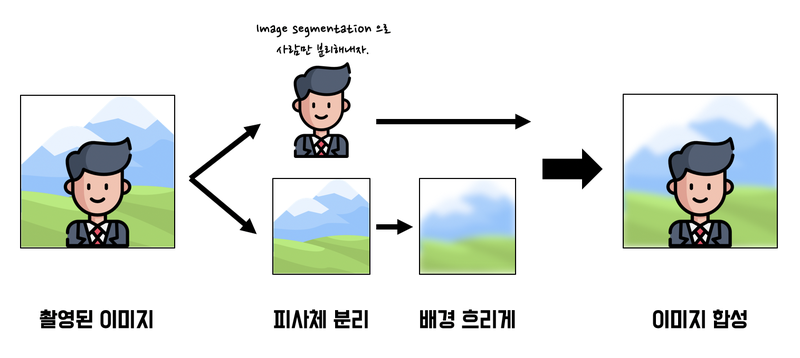

두 개의 렌즈가 맡은 역할을 하나의 렌즈에서 구현해야 하지만..... 

이미지 세그멘테이션(image segmentation) 기술을 이용하면 하나의 이미지에서 배경과 사람을 분리할 수 있고,

분리된 배경을 블러(blur) 처리 후 사람 이미지와 다시 합하면 아웃포커싱 효과를 적용한 인물 사진을 얻을 수 있다.

- 배경이 있는 셀카를 촬영합니다. (배경과 사람의 거리가 약간 멀리 있으면 좋습니다.)

- 시멘틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리합니다.

- 블러링(blurring) 기술로 배경을 흐리게 합니다.

- 피사체를 배경의 원래 위치에 합성합니다.

필요한 라이브러리 불러오기

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

준비한 이미지 불러오기

In [2]:
import os
img_path = os.getenv('HOME')+'/aiffel/EXPLORATION/08/human_segmentation/images/my_image.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(960, 720, 3)


## 세그멘테이션으로 사람 분리하기

## 세그멘테이션(Segmentation)이 뭔가요?

이미지에서 픽셀 단위로 관심 객체를 추출하는 방법을 이미지 세그멘테이션(image segmentation) 이라고 한다. 

이미지 세그멘테이션은 모든 픽셀에 라벨(label)을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정하고, 

이때 공통 특징은 물리적 의미가 없을 수도 있다. 

픽셀이 비슷하게 생겼다는 사실은 인식하지만, 우리가 아는 것처럼 실제 물체 단위로 인식하지 않을 수 있으며, 

세그멘테이션에는 여러 가지 세부 태스크가 있으며, 태스크에 따라 다양한 기준으로 객체를 추출한다.


## 시멘틱 세그멘테이션(semantic segmentation)이란?

세그멘테이션 중에서도 특히 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션을 시맨틱 세그멘테이션 이라고 하는데, 

쉽게 설명하면 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법이고 오늘 다룰 세그멘테이션 방법이다.

![https://d3s0tskafalll9.cloudfront.net/media/images/E-14-5.max-800x600_YNvIU7P.png](https://d3s0tskafalll9.cloudfront.net/media/images/E-14-5.max-800x600_YNvIU7P.png)


## 인스턴스 세그멘테이션(Instance segmentation)이란?

시맨틱 세그멘테이션은 '사람'이라는 추상적인 정보를 이미지에서 추출해내는 방법기 때문에 사람이 누구인지 관계없이 같은 라벨로 표현이 된다.

더 나아가서 인스턴스 세그멘테이션은 사람 개개인별로 다른 라벨을 가지게 하여, 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하자는 것이 목표다.

## 시맨틱 세그멘테이션 다뤄보기

DeepLab이라는 세그멘테이션 모델을 만들고 모델에 이미지를 입력해보기 

DeepLab 알고리즘(DeepLab v3+)은 세그멘테이션 모델 중에서도 성능이 매우 좋아 최근까지도 많이 사용되고 있다.

구글에서 제공하는 모델 구조를 그대로 가지고 와 DeepLabModel 클래스를 만들기|

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

사전에 학습된 가중치(pretrained weight)를 불러옵니다. 

구글에서 제공하는 파일을 다운로드하겠습니다. "model loaded successfully!"라는 문구가 뜰 때까지 오래 걸릴 수 있기.... 

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/EXPLORATION/08/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/EXPLORATION/08/human_segmentation/models
model loaded successfully!


준비한 이미지를 네트워크에 입력

In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(960, 720, 3) (513, 384, 3) 16


구글이 제공한 DeepLab은 PASCAL VOC의 라벨로 학습되었으며, 이 중 사람(person) 라벨, 즉 15를 가진 영역만 검출하기 위해 

마스크를 만들고 시각화해 보면...

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

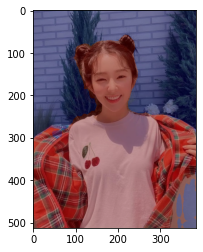

In [7]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 세그멘테이션 결과를 원래 크기로 복원하기

세그멘테이션 결과(mask)를 원래 크기로 복원

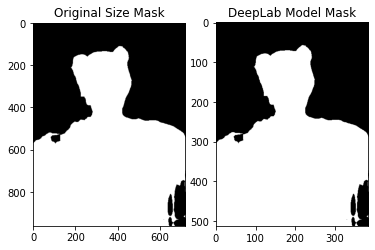

In [8]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR) 
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

더 정확히 확대하기 위해 cv2.INTER_NEAREST 말고 cv2.INTER_NEAREST 사용하여 확대

크기를 키울 때 보간(interpolation) 을 고려해야 하는데, 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우고

결과적으로 img_mask_up 은 경계가 블러된 픽셀값 0~255의 이미지를 얻는다. 

확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정하여, 128 이하의 값은 0으로 128 이상의 값은 255로 만든다.

## 배경 흐리게 하기

배경을 흐리게 만듭니다. blur()함수를 이용

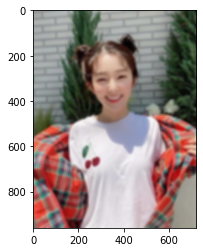

In [9]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

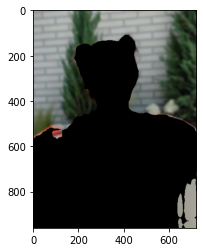

In [10]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

bitwise_not 함수를 이용하면 이미지가 반전되는데 배경은 255 사람은 0이 되며, 

반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있다

## 흐린 배경과 원본 영상 합성

배경 영상과 사람 영상을 합쳐보자..

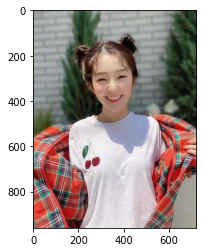

In [11]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

세그멘테이션 마스크가 255인 부분만 원본 영상을 가지고 오고 반대인 영역은 블러된 이미지 값을 사용

## 인물 모드 문제점 찾기

## Step 1. 인물모드 직접 해 보기

여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 

- 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
- 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
- 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?

## 여러 종류의 사진 샘플을 입력하기

필요한 라이브러리 가져오기

In [12]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib  # 웹에서 데이터를 다운 받을 시 사용

from matplotlib import pyplot as plt
import tensorflow as tf

이미지 불러오기

In [45]:
import os
falcon_path = os.getenv('HOME')+'/aiffel/EXPLORATION/08/human_segmentation/images/Millennium_Falcon.jpg' 
falcon_img_orig = cv2.imread(falcon_path)
rita_path = os.getenv('HOME')+'/aiffel/EXPLORATION/08/human_segmentation/images/Rita.jpg' 
rita_img_orig = cv2.imread(rita_path)
#home_path = os.getenv('HOME')+'/aiffel/EXPLORATION/08/human_segmentation/images/My_Home_VT.jpg' 
#home_img_orig = cv2.imread(home_path)
irene_path = os.getenv('HOME')+'/aiffel/EXPLORATION/08/human_segmentation/images/irene_1.jpg' 
irene_img_orig = cv2.imread(irene_path)
rita_path = os.getenv('HOME')+'/aiffel/EXPLORATION/08/human_segmentation/images/Rita.jpg' 
rita_img_orig = cv2.imread(rita_path)
heart_path = os.getenv('HOME')+'/aiffel/EXPLORATION/08/human_segmentation/images/Heart_Attack.jpg' 
heart_img_orig = cv2.imread(heart_path)


print ('홍교수님과 팔콘 : {}'.format(falcon_img_orig.shape), '릿다: {}'.format(rita_img_orig.shape), '아이린: {}'.format(home_img_orig.shape), '심쿵이: {}'.format(heart_img_orig.shape), sep ='\n')

홍교수님과 팔콘 : (1328, 2048, 3)
릿다: (4032, 3024, 3)
아이린: (450, 600, 3)
심쿵이: (720, 960, 3)


구글에서 제공하는 모델 구조를 그대로 가지고 와 DeepLabModel 클래스를 만들기|

In [37]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

구글에서 만든 DeepLab 코드 는 이미 다운로드 되어있으니 패스~~~

이미지를 리사이즈~

In [46]:
falcon_img_resized, falcon_seg_map = MODEL.run(falcon_img_orig)
rita_img_resized, rita_seg_map = MODEL.run(rita_img_orig)
irene_img_resized, irene_seg_map = MODEL.run(irene_img_orig)
heart_img_resized, heart_seg_map = MODEL.run(heart_img_orig)

print ('            (원본사이즈),   (리사이즈),   (라벨인덱스)', '---------------------------------------------------',
       '홍교수님과 팔콘 :{},{},{}'.format(falcon_img_orig.shape, falcon_img_resized.shape, falcon_seg_map.max()),
       '릿다         :{},{},{}'.format(rita_img_orig.shape, rita_img_resized.shape, rita_seg_map.max()),
       '아이린  :{},{},{}'.format(irene_img_orig.shape, irene_img_resized.shape, irene_seg_map.max()),
       '심쿵이        :{},{},{}'.format(heart_img_orig.shape, heart_img_resized.shape, heart_seg_map.max()), sep='\n')

            (원본사이즈),   (리사이즈),   (라벨인덱스)
---------------------------------------------------
홍교수님과 팔콘 :(1328, 2048, 3),(332, 513, 3),19
릿다         :(4032, 3024, 3),(513, 384, 3),15
아이린  :(960, 720, 3),(513, 384, 3),15
심쿵이        :(720, 960, 3),(384, 513, 3),8


DeepLab 에서 제공하는 라벨 종류

In [40]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

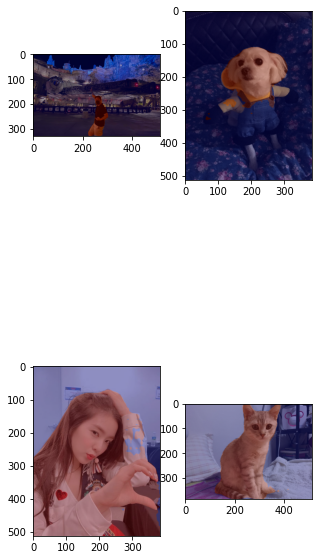

In [47]:
# falcon
falcon_img_show = falcon_img_resized.copy()
falcon_seg_map = np.where(falcon_seg_map == 15, 15, 0) 
falcon_img_mask = falcon_seg_map * (255/falcon_seg_map.max()) 
falcon_img_mask = falcon_img_mask.astype(np.uint8)
falcon_color_mask = cv2.applyColorMap(falcon_img_mask, cv2.COLORMAP_JET)
falcon_img_show = cv2.addWeighted(falcon_img_show, 0.6, falcon_color_mask, 0.35, 0.0)

# rita
rita_img_show = rita_img_resized.copy()
rita_seg_map = np.where(rita_seg_map == 12, 12, 0) 
rita_img_mask = rita_seg_map * (255/rita_seg_map.max()) 
rita_img_mask = rita_img_mask.astype(np.uint8)
rita_color_mask = cv2.applyColorMap(rita_img_mask, cv2.COLORMAP_JET)
rita_img_show = cv2.addWeighted(rita_img_show, 0.6, rita_color_mask, 0.35, 0.0)

# irene
irene_img_show = irene_img_resized.copy()
irene_seg_map = np.where(irene_seg_map == 15, 15, 0) 
irene_img_mask = irene_seg_map * (255/irene_seg_map.max())
irene_img_mask = irene_img_mask.astype(np.uint8)
irene_color_mask = cv2.applyColorMap(irene_img_mask, cv2.COLORMAP_JET)
irene_img_show = cv2.addWeighted(irene_img_show, 0.6, irene_color_mask, 0.35, 0.0)

# heart
heart_img_show = heart_img_resized.copy()
heart_seg_map = np.where(heart_seg_map == 8, 8, 0) 
heart_img_mask = heart_seg_map * (255/heart_seg_map.max())
heart_img_mask = heart_img_mask.astype(np.uint8)
heart_color_mask = cv2.applyColorMap(heart_img_mask, cv2.COLORMAP_JET)
heart_img_show = cv2.addWeighted(heart_img_show, 0.6, heart_color_mask, 0.35, 0.0)


# figsize
plt.figure(figsize=(5, 12))



# falcon
ax = plt.subplot(2,2,1)
plt.imshow(cv2.cvtColor(falcon_img_show, cv2.COLOR_BGR2RGB))

# rita
ax = plt.subplot(2,2,2)
plt.imshow(cv2.cvtColor(rita_img_show, cv2.COLOR_BGR2RGB))

# irene
ax = plt.subplot(2,2,3)
plt.imshow(cv2.cvtColor(irene_img_show, cv2.COLOR_BGR2RGB))

# heart
ax = plt.subplot(2,2,4)
plt.imshow(cv2.cvtColor(heart_img_show, cv2.COLOR_BGR2RGB))
plt.show()



원본사이즈와 리사이즈 비교

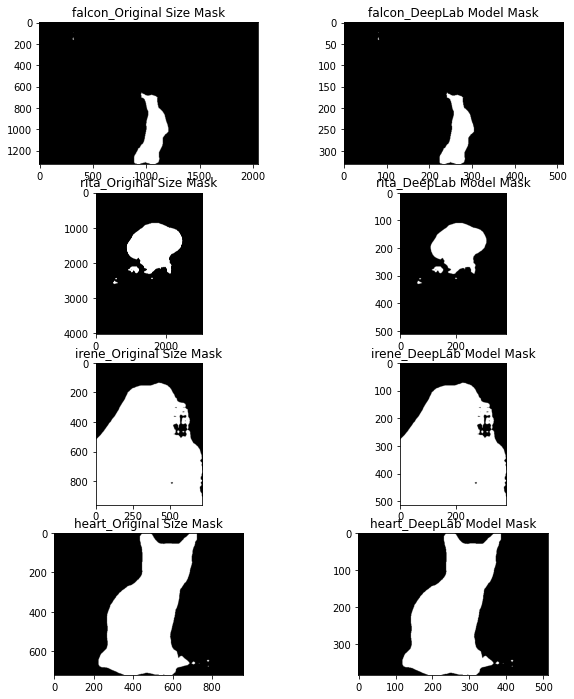

In [48]:
# falcon
falcon_img_mask_up = cv2.resize(falcon_img_mask, falcon_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, falcon_img_mask_up = cv2.threshold(falcon_img_mask_up, 128, 255, cv2.THRESH_BINARY)
# rita
rita_img_mask_up = cv2.resize(rita_img_mask, rita_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, rita_img_mask_up = cv2.threshold(rita_img_mask_up, 128, 255, cv2.THRESH_BINARY)
# irene
irene_img_mask_up = cv2.resize(irene_img_mask, irene_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, irene_img_mask_up = cv2.threshold(irene_img_mask_up, 128, 255, cv2.THRESH_BINARY)
# heart
heart_img_mask_up = cv2.resize(heart_img_mask, heart_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, heart_img_mask_up = cv2.threshold(heart_img_mask_up, 128, 255, cv2.THRESH_BINARY)


# figsize
plt.figure(figsize=(10, 12))


# falcon
ax = plt.subplot(4,2,1)
plt.imshow(falcon_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('falcon_Original Size Mask')

ax = plt.subplot(4,2,2)
plt.imshow(falcon_img_mask, cmap=plt.cm.binary_r)
ax.set_title('falcon_DeepLab Model Mask')

# rita
ax = plt.subplot(4,2,3)
plt.imshow(rita_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('rita_Original Size Mask')

ax = plt.subplot(4,2,4)
plt.imshow(rita_img_mask, cmap=plt.cm.binary_r)
ax.set_title('rita_DeepLab Model Mask')

# irene
ax = plt.subplot(4,2,5)
plt.imshow(irene_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('irene_Original Size Mask')

ax = plt.subplot(4,2,6)
plt.imshow(irene_img_mask, cmap=plt.cm.binary_r)
ax.set_title('irene_DeepLab Model Mask')

# heart
ax = plt.subplot(4,2,7)
plt.imshow(heart_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('heart_Original Size Mask')

ax = plt.subplot(4,2,8)
plt.imshow(heart_img_mask, cmap=plt.cm.binary_r)
ax.set_title('heart_DeepLab Model Mask')




plt.show()

세그멘테이션 마스크를 이용해 배경만 추출하기

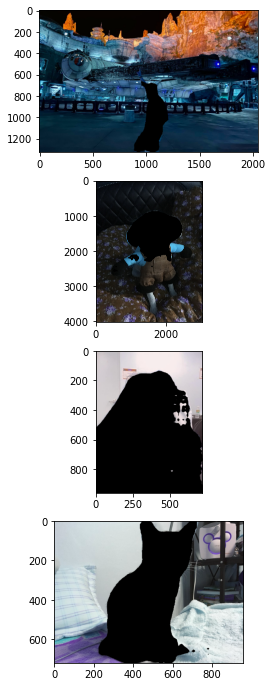

In [49]:
# falcon
falcon_img_mask_color = cv2.cvtColor(falcon_img_mask_up, cv2.COLOR_GRAY2BGR)
falcon_img_bg_mask = cv2.bitwise_not(falcon_img_mask_color)  # 이미지가 반전되어 배경: 255, 사람: 0
falcon_img_bg = cv2.bitwise_and(falcon_img_orig, falcon_img_bg_mask)  # 배경만 있는 영상 얻기

# rita
rita_img_mask_color = cv2.cvtColor(rita_img_mask_up, cv2.COLOR_GRAY2BGR)
rita_img_bg_mask = cv2.bitwise_not(rita_img_mask_color)  # 이미지가 반전되어 배경: 255, 사람: 0
rita_img_bg = cv2.bitwise_and(rita_img_orig, rita_img_bg_mask)  # 배경만 있는 영상 얻기

# irene
irene_img_mask_color = cv2.cvtColor(irene_img_mask_up, cv2.COLOR_GRAY2BGR)
irene_img_bg_mask = cv2.bitwise_not(irene_img_mask_color)  # 이미지가 반전되어 배경: 255, 사람: 0
irene_img_bg = cv2.bitwise_and(irene_img_orig, irene_img_bg_mask)  # 배경만 있는 영상 얻기

# heart
heart_img_mask_color = cv2.cvtColor(heart_img_mask_up, cv2.COLOR_GRAY2BGR)
heart_img_bg_mask = cv2.bitwise_not(heart_img_mask_color)  # 이미지가 반전되어 배경: 255, 사람: 0
heart_img_bg = cv2.bitwise_and(heart_img_orig, heart_img_bg_mask)  # 배경만 있는 영상 얻기


# figsize
plt.figure(figsize=(10, 12))


# falcon
ax = plt.subplot(4,1,1)
plt.imshow(falcon_img_bg)

# rita
ax = plt.subplot(4,1,2)
plt.imshow(rita_img_bg)

# irene
ax = plt.subplot(4,1,3)
plt.imshow(irene_img_bg)

# heart
ax = plt.subplot(4,1,4)
plt.imshow(heart_img_bg)


plt.show()

이미지 blur 처리하기

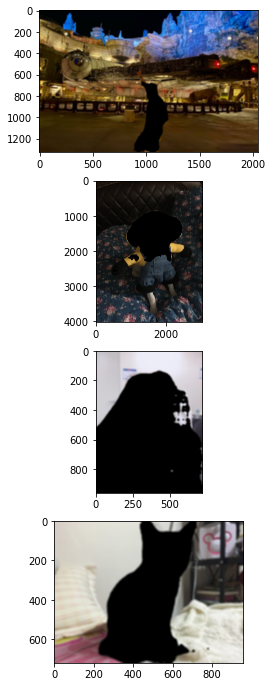

In [50]:
# figsize
plt.figure(figsize=(10, 12))


# falcon
ax = plt.subplot(4,1,1)
falcon_img_bg_blur = cv2.blur(falcon_img_bg, (13,13))
plt.imshow(cv2.cvtColor(falcon_img_bg_blur, cv2.COLOR_BGR2RGB))

# rita
ax = plt.subplot(4,1,2)
rita_img_bg_blur = cv2.blur(rita_img_bg, (13,13))
plt.imshow(cv2.cvtColor(rita_img_bg_blur, cv2.COLOR_BGR2RGB))

# irene
ax = plt.subplot(4,1,3)
irene_img_bg_blur = cv2.blur(irene_img_bg, (13,13))
plt.imshow(cv2.cvtColor(irene_img_bg_blur, cv2.COLOR_BGR2RGB))

# heart
ax = plt.subplot(4,1,4)
heart_img_bg_blur = cv2.blur(heart_img_bg, (13,13))
plt.imshow(cv2.cvtColor(heart_img_bg_blur, cv2.COLOR_BGR2RGB))


plt.show()


배경이미지와 사람이미지 합성하기

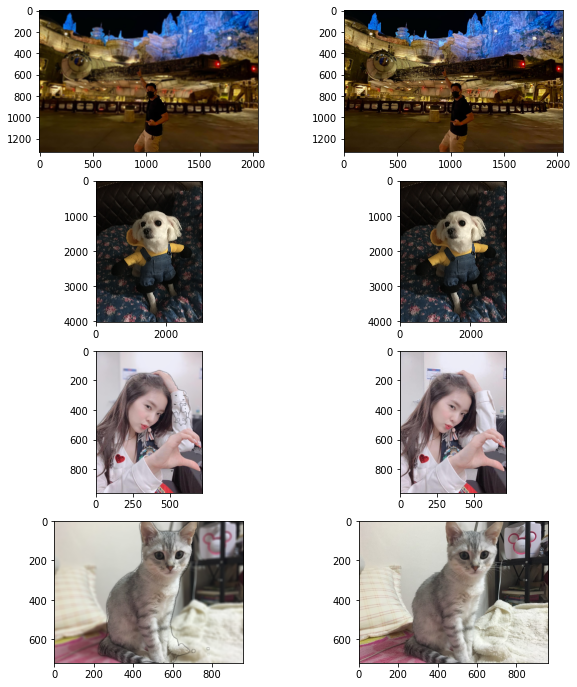

In [52]:
# figsize
plt.figure(figsize=(10, 12))


# falcon
ax = plt.subplot(4,2,1)
falcon_img_concat = np.where(falcon_img_mask_color==255, falcon_img_orig, falcon_img_bg_blur)
plt.imshow(cv2.cvtColor(falcon_img_concat, cv2.COLOR_BGR2RGB))

ax = plt.subplot(4,2,2)
plt.imshow(cv2.cvtColor(falcon_img_orig, cv2.COLOR_BGR2RGB))


# rita
ax = plt.subplot(4,2,3)
rita_img_concat = np.where(rita_img_mask_color==255, rita_img_orig, rita_img_bg_blur)
plt.imshow(cv2.cvtColor(rita_img_concat, cv2.COLOR_BGR2RGB))

ax = plt.subplot(4,2,4)
plt.imshow(cv2.cvtColor(rita_img_orig, cv2.COLOR_BGR2RGB))


# irene
ax = plt.subplot(4,2,5)
irene_img_concat = np.where(irene_img_mask_color==255, irene_img_orig, irene_img_bg_blur)
plt.imshow(cv2.cvtColor(irene_img_concat, cv2.COLOR_BGR2RGB))

ax = plt.subplot(4,2,6)
plt.imshow(cv2.cvtColor(irene_img_orig, cv2.COLOR_BGR2RGB))

# heart
ax = plt.subplot(4,2,7)
heart_img_concat = np.where(heart_img_mask_color==255, heart_img_orig, heart_img_bg_blur)
plt.imshow(cv2.cvtColor(heart_img_concat, cv2.COLOR_BGR2RGB))

ax = plt.subplot(4,2,8)
plt.imshow(cv2.cvtColor(heart_img_orig, cv2.COLOR_BGR2RGB))



plt.show()

사진에서 문제점 찾기

두번째 이미지(rita) 와 세번째 이미지(irene) 에서 특정 부분이 같이 추출되어 블러처리가 되지 않았다.

두번째 이미지는 어째서인지 오른쪽 팔부분이 강아지와 동일하게 인식이 되었고 3번째 이미지에서는 왼쪽팔의 옷부분이 부분부분 인식이 되면서 세세하게 원하는대로 인식이 되지 않았다.

그에비해 첫번째 이미지와 4번째 이미지는 내 기준에서는 잘 인식되어 처리된것으로 보인다..

## 배경이미지를 바꿔보자,.

데이터 불러오기

In [59]:
rita_path = os.getenv('HOME')+'/aiffel/EXPLORATION/08/human_segmentation/images/Rita.jpg' 
rita_img_orig = cv2.imread(rita_path)
home_path = os.getenv('HOME')+'/aiffel/EXPLORATION/08/human_segmentation/images/My_Home_VT.jpg' 
home_img_orig = cv2.imread(home_path)

print ('rita: {}'.format(rita_img_orig.shape), '배경: {}'.format(home_img_orig.shape),sep ='\n')

rita: (4032, 3024, 3)
배경: (450, 600, 3)


리사이즈 확인하기

In [67]:
rita_img_resized, rita_seg_map = MODEL.run(rita_img_orig)
home_img_resized = cv2.resize(home_img_orig, (3024,4032))

print ('           (원본사이즈), (리사이즈), (라벨인덱스)', '---------------------------------------------------',
       'rita :{},{},{}'.format(rita_img_orig.shape, rita_img_resized.shape, rita_seg_map.max()),
       '배경 :{},{}'.format(home_img_orig.shape, home_img_resized.shape),sep='\n')

           (원본사이즈), (리사이즈), (라벨인덱스)
---------------------------------------------------
rita :(4032, 3024, 3),(513, 384, 3),15
배경 :(450, 600, 3),(4032, 3024, 3)


배경합성 사진과 원본 사진 비교

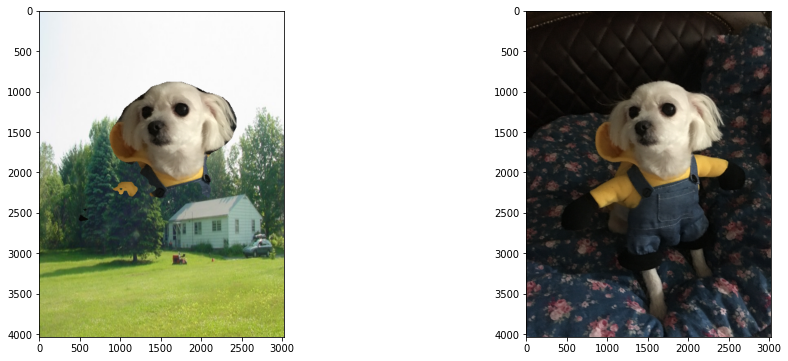

In [68]:
# 시맨틱 세그멘테이션
rita_img_show = rita_img_resized.copy()
rita_seg_map = np.where(rita_seg_map == 12, 12, 0) 
rita_img_mask = rita_seg_map * (255/rita_seg_map.max()) 
rita_img_mask = rita_img_mask.astype(np.uint8)
rita_color_mask = cv2.applyColorMap(rita_img_mask, cv2.COLORMAP_JET)
rita_img_show = cv2.addWeighted(rita_img_show, 0.6, rita_color_mask, 0.35, 0.0)

# 마스크업
rita_img_mask_up = cv2.resize(rita_img_mask, rita_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)

# 떼어놓기
rita_img_mask_color = cv2.cvtColor(rita_img_mask_up, cv2.COLOR_GRAY2BGR)

plt.figure(figsize=(16, 6))

# 합성과 원본 비교
ax = plt.subplot(1,2,1)
rita_img_concat = np.where(rita_img_mask_color==255, rita_img_orig, home_img_resized)
plt.imshow(cv2.cvtColor(rita_img_concat, cv2.COLOR_BGR2RGB))

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(rita_img_orig, cv2.COLOR_BGR2RGB))

plt.show()

앗 착각.... 풀밭을 배경으로 릿다가 서있는 모습을 합성하려구 햇는데... 릿다 몸 전체가 인식되지 않았다는 점을 까먹음....

홍교수님 출격...

In [70]:
falcon_path = os.getenv('HOME')+'/aiffel/EXPLORATION/08/human_segmentation/images/Millennium_Falcon.jpg' 
falcon_img_orig = cv2.imread(falcon_path)
home_path = os.getenv('HOME')+'/aiffel/EXPLORATION/08/human_segmentation/images/My_Home_VT.jpg' 
home_img_orig = cv2.imread(home_path)

print ('falcon: {}'.format(falcon_img_orig.shape), '배경: {}'.format(home_img_orig.shape),sep ='\n')

falcon: (1328, 2048, 3)
배경: (450, 600, 3)


In [71]:
falcon_img_resized, falcon_seg_map = MODEL.run(falcon_img_orig)
home_img_resized = cv2.resize(home_img_orig, (2048,1328))

print ('           (원본사이즈), (리사이즈), (라벨인덱스)', '---------------------------------------------------',
       'rita :{},{},{}'.format(falcon_img_orig.shape, falcon_img_resized.shape, falcon_seg_map.max()),
       '배경 :{},{}'.format(home_img_orig.shape, home_img_resized.shape),sep='\n')

           (원본사이즈), (리사이즈), (라벨인덱스)
---------------------------------------------------
rita :(1328, 2048, 3),(332, 513, 3),19
배경 :(450, 600, 3),(1328, 2048, 3)


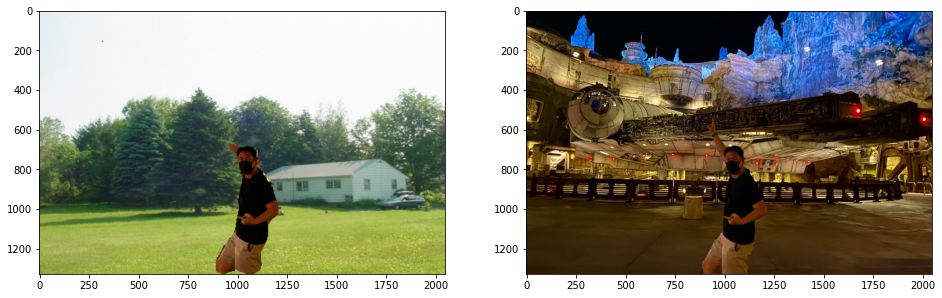

In [73]:
# 시맨틱 세그멘테이션
falcon_img_show = falcon_img_resized.copy()
falcon_seg_map = np.where(falcon_seg_map == 15, 15, 0) 
falcon_img_mask = falcon_seg_map * (255/falcon_seg_map.max()) 
falcon_img_mask = falcon_img_mask.astype(np.uint8)
falcon_color_mask = cv2.applyColorMap(falcon_img_mask, cv2.COLORMAP_JET)
falcon_img_show = cv2.addWeighted(falcon_img_show, 0.6, falcon_color_mask, 0.35, 0.0)

# 마스크업
falcon_img_mask_up = cv2.resize(falcon_img_mask, falcon_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)

# 떼어놓기
falcon_img_mask_color = cv2.cvtColor(falcon_img_mask_up, cv2.COLOR_GRAY2BGR)

plt.figure(figsize=(16, 6))

# 합성과 원본 비교
ax = plt.subplot(1,2,1)
falcon_img_concat = np.where(falcon_img_mask_color==255, falcon_img_orig, home_img_resized)
plt.imshow(cv2.cvtColor(falcon_img_concat, cv2.COLOR_BGR2RGB))

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(falcon_img_orig, cv2.COLOR_BGR2RGB))

plt.show()

경계선이 정확하게 구분되지 않아서... 살짝 어색한... 

원본 이미지 사이즈만 알면 앞에서 만들어 놨던것을 그대로 불러와서 합성이 가능하지 않을까?

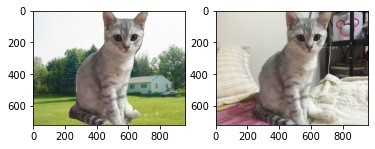

In [74]:
home_img_resized = cv2.resize(home_img_orig, (960,720))


ax = plt.subplot(1,2,1)
heart_img_concat = np.where(heart_img_mask_color==255, heart_img_orig, home_img_resized)
plt.imshow(cv2.cvtColor(heart_img_concat, cv2.COLOR_BGR2RGB))

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(heart_img_orig, cv2.COLOR_BGR2RGB))

plt.show()

## 회고

- 처음 테스트해볼 이미지를 선택하는데 있어서 구글이 제공한 DeepLab의 20개의 라벨링된 정보를 가지고 있는데.... 인식가능한 라벨 데이터중... horse를... house로 잘못 봐서... house 이미지를 준비하고 테스트를 돌리다가...왜 집을 인식을 못할까.. 집이 너무 멀리 있어서 인식을 못하나? 등 별의별 삽질을 하다가... 내가 라벨을 잘못 읽은것을 확인하고 해당 이미지를 다른것으로 테스트했다가.. 나중에 배경으로 활용하게 되었다..

- 내가 인식하고자 하는 대상의 경계선이 모호하고 종류에 따라 인식율이 달라져서 배경과 피사체를 분리하는데 있어서 오류가 발생하여 원라는 결과값을 얻지 못한 경우도 있다. (첫번째 테스트에서 사람의 경우 옷을 입은 상태의 전신을 사람으로 잘 인식한 반면에 2번 이미지의 강아지에 옷을 입은 경우 옷을 입은 상태의 전신을 인식하지 못하고 몸의 일부부분만 인식 하였다. 아무래도 동물이 옷을 착용한 부분까지 DeepLab의 데이터가 처리하지 못하는것 같다.

- 의외로 사람은 잘 인식하는것 같다. 살짝... 옷부분에서 인식이 떨어져서 배경과의 분리가 안된 부분도 있지만 테스트 1번 이미지에서 배경이 어두우면서 피사체도 어두운 복장인 경우에도 나름 잘 인식해서 분리해 내는것을 확인할수 있었다.

- LMS에서 문제점이 발생했을때 그 문제를 해결하는 방법에 대해 여러 예시를 들었지만... ~~그중에서 피사계 심도를 이해한뒤 깊이 영상(Depth image) 활용하기 방법에 주목하게 되었다.~~ 일반적으로 듀얼카메라가 장착되어 인물 사진 모드를 제공하기 시작한 3D Depth Camera 를 활용하는 방법은 이미 하드웨어 지원으로 피사체와 배경을 분리하기 좋은 상태이며 IR(적외선)을 활용한 사례 역시 추가적인 하드웨어의 힘을 이용한데 반해서 해당 노드의 주제에 부함된 싱글렌즈를 통해서 2D 이미지에서 깊이 영상을 구해서 분리해 내는 방법은 ~~기존에 촬영되었던 이미지들에 적용이 가능하리라 생각되었다.~~ 없는것인가? 깊이 영상 또한... 찾아보니 두개의 카메라롤 촬영을 해서 깊이 값을 찾는게 3D Depth Camera와 별반 차이가 없어 보였다.

- 단일렌즈로 찍은 사진으로 인물사진을 만들어내는것은 이해를 돕기위한 추가 설명의 아웃포커싱 방법과 원리 (https://ggyul.tistory.com/12)를 보면 좀더 이해할수 있엇다. 예전에 DSLR을 통해 .8 렌즈를 통해서 무수한 아웃포커싱 이미지를 생산해 냈었는데.. 이미 원본 이미지가 아웃포커싱이 된 인물사진이라면.. 이런 작업이 필요없는것이었다.. (생각해보니 테스트 이미지를 찾을때 아이린 이미지를 검색해봣더니.. 죄다 인물사진이라 인물사진 테스트에 적합한 아웃포커싱이 되지 않은 이미지를 찾기가 힘들었다는것을 까먹구 있었다..

- 이미지에서 배경을 분리한뒤 아웃포커싱 효과(블러처리)를 한뒤 피사체와 배경을 합치는 방법은 처음부터 이미지를 만들어 내는 상태에서 추가적인 장비의 힘을 빌려야만 가능한것인가? 그냥 찍은 이미지에서 심도값을 유추해서 좀더 확실히 원하는 피사체와 배경을 분리하는 방법은 없을까 하며 찾아보던차에... Nvidia 에서 2D이미지를 3D 모델로 변환해 가상 환경에서 시각화와 제어를 가능하게 하는 기술이 개발되었음을 찾을수 있었다.
https://blogs.nvidia.com/blog/2021/04/16/gan-research-knight-rider-ai-omniverse/


![](https://github.com/MulderKim/EXPLORATION/blob/main/08/human_segmentation/etc/GANverse3D.jpg?raw=true)

- 새롭게 궁금해진점... 가능성이 있지 않을까 생각된 점은 우리가 일반적으로 학습데이터를 늘리기 위해(?) 사용하는 data augmentation 기능을.. 이용하면 그래서 미세하게 이미지를 회전시키면서 추가 이미지를 얻을수 있다면... 퀄리티 있는 이미지를 얻을수 있다면... 2D 이미지를 3D 이미지로 변환하는데 있어서 부족한 부분의 이미지를 채울수 있는 데이터를 얻을수가 있지 않을까? 그리고 그 데이터를 이용해서.. 피사체와 배경을 분리하는것 뿐만 아니라 3D 이미지를 생성할수 있지 않을까 생각해본다.